**Capacity Fade Estimation on Raspberry Pi**

---


Data FIle: Qi Data File (Q0Test_data_25C_Test0.csv)

---


Authors: [Anandha Natarajan](https://github.com/natarajan95), [Moinak Pyne](https://github.com/MoinakPyne), Energy Storage Systems Lab, The University of Texas at Dallas



---

**To Do:**

*   Introduce 70-30 train-validation split on the data file to exhibit it's actual working
*   Feel free to play with Epoch, Batch Size and other parameters for desired results
*   Visualization of results coming up!



In [24]:
import tensorflow as tf
import keras as k
from keras.layers import Dense
from keras.models import Sequential
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly

print(tf.__version__, k.__version__)

# matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

1.9.0 2.2.4


NameError: name 'figure' is not defined

In [15]:
# Read training data onto dataframe (5 Columns; Time, Voltage, Current, Temp, SOC; First Row is header)
train_df0 = pd.read_csv("./Q0Test_data_25C_Test0.csv", header=0)

# If multiple files are to be used in future, following line may be used to concat
train_df = pd.concat([train_df0])

# Check for missing entries on dataframe. If so, stop execution
temp_check_missing = np.where(train_df['Current'].isna())

if temp_check_missing[0].size:
  print("Error. Missing Elements in Data File")


In [16]:
# Reorder Columns and look at a sample 
train_df=train_df.reindex(columns=["Temp", "Current", "Voltage", "SOC"])
train_df.head()




,Temp,Current,Voltage,SOC
0,24.19694,0.0,12.47880,100.0
1,24.16815,0.0,12.47891,100.0
2,24.17414,0.0,12.47868,100.0
3,24.18038,0.0,12.47868,100.0
4,24.17407,0.0,12.47885,100.0


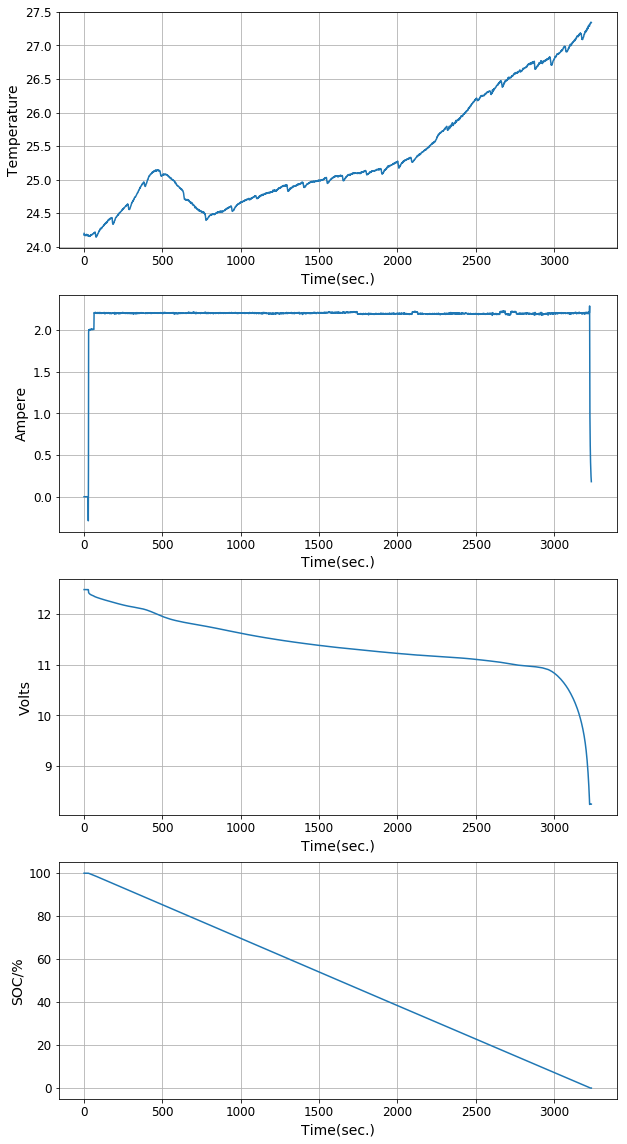

In [31]:
# Looking at the behavior of the data
Temp=train_df.iloc[:,0].values
Current=train_df.iloc[:,1].values
Voltage=train_df.iloc[:,2].values
SOC=train_df.iloc[:,3].values

plt.figure(figsize=(10,20))
plt.subplot(411)
plt.plot(Temp)
plt.ylabel('Temperature')
plt.xlabel('Time(sec.)')
plt.grid(True)

plt.subplot(412)
plt.plot(Current)
plt.ylabel('Ampere')
plt.xlabel('Time(sec.)')
plt.grid(True)

plt.subplot(413)
plt.plot(Voltage)
plt.ylabel('Volts')
plt.xlabel('Time(sec.)')
plt.grid(True)

plt.subplot(414)
plt.plot(SOC)
plt.ylabel('SOC/%')
plt.xlabel('Time(sec.)')
plt.grid(True)

plt.show()


In [0]:
# Using Temperature and Voltage data for input
# Using SOC value as Output
train_x = train_df.iloc[:, 1:3].values
train_y = train_df.iloc[:, 3].values

In [5]:
# Define a sequential Model
model = Sequential()
model.add(Dense(10, input_dim=2, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Define Optimizers and other parameters
from keras import optimizers
opt_var = optimizers.Adam(lr=0.0001)
loss_var = 'mean_squared_error'
metrics_monitor = ['cosine_proximity']
epoch = 10
batch_sz = 16

In [7]:
# Compile and view model summary
model.compile(loss=loss_var, optimizer=opt_var, metrics=metrics_monitor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train network
model.fit(train_x, train_y, epochs=epoch, batch_size=batch_sz)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3238/3238 [==============================] - 0s 107us/step - loss: 3384.3848 - cosine_proximity: -0.9997
Epoch 2/10
3238/3238 [==============================] - 0s 54us/step - loss: 3377.3073 - cosine_proximity: -0.9997
Epoch 3/10
3238/3238 [==============================] - 0s 55us/step - loss: 3361.6045 - cosine_proximity: -0.9997
Epoch 4/10
3238/3238 [==============================] - 0s 56us/step - loss: 3328.7383 - cosine_proximity: -0.9997
Epoch 5/10
3238/3238 [==============================] - 0s 56us/step - loss: 3273.5288 - cosine_proximity: -0.9997
Epoch 6/10
3238/3238 [==============================] - 0s 56us/step - loss: 3193.5481 - cosine_proximity: -0.9997
Epoch 7/10
3238/3238 [==============================] - 0s 58us/step - loss: 3087.6852 - cosine_proximity: -0.9997
Epoch 8/10
3238/3238 [==============================] - 0s 55us/step - loss: 2956.6388 - cosine_proximity: -0.9997
Epoch 9/10
3238/3238 [=========

In [9]:
# Validation file list

test_files = ["./Q0Test_data_25C_Test0.csv"]
              
actual_soc_list = []
pred_soc_list = []
actual_op_list = []
pred_op_list = []


for file_name in test_files:
  test_df = pd.read_csv(file_name, header=0)
  test_df = test_df.reindex(columns=["Current", "Temp", "Voltage", "SOC"])
  test_x = test_df.iloc[:, 1:3].values
  y_actual = test_df.iloc[:, 3].values

  # Model prediction
  y_pred = model.predict(test_x)
  
  # Curve fit through predicted values - Shift the curve to start at 100%
  
  x = np.arange(0, len(y_pred))
  y = np.nan_to_num(y_pred)
  coefs2 = poly.polyfit(x, y-100, [1])
  coefs2 = np.squeeze(coefs2)
  coefs2[0] = 100
  x = np.arange(0, len(y_pred)+500)
  ffit2 = poly.polyval(x,coefs2)
  y_pred = ffit2

  # Cutoff all values above 100 % and below 0 %
  y_pred[y_pred > 100] = 100
  y_pred[y_pred < 0] = 0
  
  actual_soc = test_df.iloc[:,3].values
  # Store entire list of actual SOC values for future use
  actual_op_list.append(actual_soc)
  pred_soc = y_pred
  # Store entire list of predcited SOC values for future use
  pred_op_list.append(pred_soc)

  # Capacity Estimation
  actual_ix = -1
  pred_ix = -1
  # Locate point where the actual and predicted curves reach 0% SOC
  for ix, item in enumerate(actual_soc):
    if item < 0.05:
      actual_ix = ix; break;

  for ix, item in enumerate(pred_soc):
    if item < 0.05:
      pred_ix = ix; break;
  # Identify Capacity by summing currents across the entire cycle; Percent error
  pred_soc_value = pred_ix*2.2/3600
  actual_soc_value = actual_ix*2.2/3600
  percent_error = ((actual_soc_value - pred_soc_value)*100/actual_soc_value)
  # Display
  print("File Name       : ", file_name)
  print("Predicted SOC   : ", pred_soc_value)
  print("Actual SOC      : ", actual_soc_value)
  print("Percent Error   : ",percent_error)
  actual_soc_list.append(actual_soc_value)
  pred_soc_list.append(pred_soc_value)

File Name       :  ./Q0Test_data_25C_Test0.csv
Predicted SOC   :  1.4550555555555558
Actual SOC      :  1.973277777777778
Percent Error   :  26.262000619386804
